In [1]:
!pip install gensim

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import os
import glob
from datetime import datetime
import string
from collections import Counter
from tqdm import tqdm, notebook
tqdm.pandas()

# don't display warnings info
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Gensim
# !pip install --upgrade gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet
# set the environment for mallet
os.environ.update({'MALLET_HOME':r'C:\Users\wessa\DsinLS\Week8\TopicModeling\mallet-2.0.8'})
mallet_path = r'C:\Users\wessa\DsinLS\Week8\TopicModeling\mallet-2.0.8\bin\mallet'# update this path

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Nltk for text processing
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

# spacy for lemmatization
import spacy


# model storage
import pickle
import joblib

C:\Users\wessa\Anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wessa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\wessa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wessa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wessa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
#Read, Sort, Rearrange Dataset

In [4]:
root_path = '../Euronews/'
all_files = glob.glob(root_path + "/*.xlsx")
li = []
for filename in all_files:
    df = pd.read_excel(filename, index_col=None, header=0)
    li.append(df)

EuroNewsDF = pd.concat(li, axis=0, ignore_index=True)
EuroNewsDF=EuroNewsDF.dropna()
col = ['published_date', 'headline', 'content', 'link']
EuroNewsDF = EuroNewsDF[col]
EuroNewsDF['Platform']="Euronews"
EuroNewsDF['published_date'] =  pd.to_datetime(EuroNewsDF['published_date'], format="%d/%m/%Y")
EuroNewsDF=EuroNewsDF.sort_values(by='published_date')
EuroNewsDF.head()

,published_date,headline,content,link,Platform
1512,2020-02-05,Coronavirus outbreak: 39 additional cases of v...,An additional 39 passengers on a cruise ship i...,https://www.euronews.com/2020/02/05/ten-people...,Euronews
1511,2020-02-10,Coronavirus latest: World Health Organisation ...,COVID-19. The coronavirus has a new name but s...,https://www.euronews.com/2020/02/10/coronaviru...,Euronews
1510,2020-02-12,Can COVID-19 be transmitted through water pipe...,Health authorities in Hong Kong quarantined ro...,https://www.euronews.com/2020/02/12/coronaviru...,Euronews
1506,2020-02-12,COVID-19 coronavirus spreads to Africa as Egyp...,The COVID-19 coronavirus spread to a new conti...,https://www.euronews.com/2020/02/12/watch-live...,Euronews
1507,2020-02-12,'Are there any Chinese there?' Greek tourism h...,The effects of the Covid-19 coronavirus are no...,https://www.euronews.com/2020/02/12/greek-tour...,Euronews


In [5]:
#Clean Content

In [6]:
# Check for duplicated rows 
EuroNewsDF[EuroNewsDF.duplicated(subset = 'content')]
# Check the 'stop sentences'
all_news = ' '.join(''.join(df['content']).split('\xa0')) #exclude \xa0
all_news_sentences = sent_tokenize(all_news) # get all the sentences
Counter(all_news_sentences).most_common()

[('People who regularly work from home are twice as likely to work more than 48 hours a week and six times more likely to work during their free time.',
  2),
 ('In most cases, this extra work goes unpaid.', 2),
 ('Our rights were won through protests and on picket lines, but the most radical thing you could do to defend them is to close your emails and log-off.',
  2),
 ('The effects of coronavirus have been so extraordinary that even Space has not been immune.',
  1),
 ('Politicians in Europe warn that the economic impact on the space industry could be up to €1 billion.',
  1),
 ('This is partly down to private sector investments falling away in the economic slump.',
  1),
 ('Olivier Lemaitre, secretary-general of Eurospace, says he expects private customers will be investing less in satellite operations this year.',
  1),
 ("He believes that the space industry will need 'huge institutional support' for research and development activities.",
  1),
 ("It is something, Lemaitre says, t

In [7]:
stop_sentences = ['contributed to this', 
                  'This material may not be published, broadcast, rewritten, or redistributed', 
                  'All rights reserved',
                  'All market data delayed',
                  'Sign up here',
                  "Get all the stories you need-to-know from the most powerful name in news delivered first thing every morning to your inbox Subscribed You've successfully subscribed to this newsletter! This material may not be published, broadcast, rewritten, or redistributed",
                  "LIMITED TIME OFFER, ",
                  r"Learn about all the*",
                  r'Get[ ]*latest[ ]*news',
                  r"delivered[ ]*daily[ ]*inbox",
                  r"Check out what's clicking[ ,\w]*",
                  r"successfully subscribed to[ ,\w]*",
                  r"Thank you for making us your first choice[ ,\w]*",
                  r"Flash top[ \w,]*headlines",
                  r"CLICK HERE*",
                  "Mobile users click here",
                  r"Fun stories about [\w,]* and more",
                  r"Stay up-to-date on the biggest [\w,]* news with our weekly recap",
                  r"originally appeared on [\w,]*",
                  r"originally published on [\w,]*",
                  r"Get a daily look at[ \w,]*",
                  "The FOX NEWS RUNDOWN",
                  "subscribe and download",
                  "copyright",
                  "Follow below on the Fox News live blog",
                  "Kim Komando Show",
                  # stop sentences from Euronews
                  'Watch the latest videos on Covid-19.',
                  r'live[ ]*coverage[ ]*of[ \w]*',
                  "Note: The prices above reflect the retailer's listed price at the time of publication.",
                  "Read the full story here.",
                  r"EURONEWS Coronavirus",
                  r"A version of this article first appeared",
                  "You can sign up for free right here",
                  "At EURONEWS, we start with the facts.",
                  "Visit EURONEWS's home for Facts First.",
                  "delivered to your inbox daily.",
                  "Sign up here.",
                  "Darren McCaffrey is Euronews' political editor"
                  "EURONEWS platforms",
                  "EURONEWS NOW",
                  "Contact us at view@euronews.com to send pitches or submissions and be part of the conversation"
                  ]
stop_sentences = [*map(lambda x: x.lower(), stop_sentences)]



def contain_stop_sentences(sentence):
    '''
    extract the sentences that contain stop sentences
    '''
    check_status = [*map(lambda x: bool(re.search(x, sentence)), stop_sentences)]
    return(any(check_status))
def extract_no_stop_sentences(text_data):
    '''
    Applied on dataframe's column level,
    to delete the stop sentences from a whole news article
    '''
    single_news = ' '.join(''.join(text_data).lower().split('\xa0')) #exclude \xa0
    single_news_sentences = sent_tokenize(single_news)
    new_sentences = []
    for x in single_news_sentences:
        if contain_stop_sentences(x) is False:
            new_sentences.append(x)
    single_new_news = ' '.join(new_sentences)
    
    return(single_new_news)

new_news_list = EuroNewsDF['content'].progress_apply(extract_no_stop_sentences)
EuroNewsDF.loc[:,'true_content'] = new_news_list

100%|█████████████████████████████████████████████████████████████████████████████| 1489/1489 [00:02<00:00, 634.70it/s]


In [8]:
# Pre-process the text before stemming

In [9]:
# remove punctuations
def make_lower(text):
    return text.lower()

def remove_punctuation(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) 
    text = re.sub("\'", "", text)
    return re.sub(r'[^\w\s]', ' ', text)

def strip_extraspace(text):
    return ' '.join(text.split())

def remove_digits(text):
    return re.sub('\d', ' ', text)

def replace_word(text,word,replacement):
    return text.replace(word,replacement)

def remove_words(text,wordlist):
    for word in wordlist:
        if word in text.split():
            text = re.sub(r'\b{}\b'.format(word), '', text)  
    return text

stop_words = stopwords.words('english')
stop_words.append('coronavirus')
stop_words.append('Euronews')


def clean_text(text):
    text = make_lower(text)
    text = replace_word(text,'covid-19','covid') 
    text = replace_word(text,'corona virus','coronavirus') 
    text = replace_word(text,'covid','coronavirus') 
    text = replace_word(text,'Euro news','Euronews') 
    text = replace_word(text,'new york','newyork')
    text = replace_word(text, 'begin video clip', '')
    text = replace_word(text, 'commercial break', '')
    text = remove_punctuation(text)
    text = remove_digits(text)
    text = remove_words(text,stop_words)
    return text
    

EuroNewsDF['clean_content'] = EuroNewsDF['true_content'].progress_apply(lambda x:clean_text(x))
data = EuroNewsDF.clean_content.values.tolist()

100%|█████████████████████████████████████████████████████████████████████████████| 1489/1489 [00:12<00:00, 118.27it/s]


In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
data_words[:2]

[['additional',
  'passengers',
  'cruise',
  'ship',
  'japan',
  'tested',
  'positive',
  'novel',
  'bringing',
  'total',
  'cases',
  'linked',
  'ship',
  'least',
  'japanese',
  'authorities',
  'placed',
  'diamond',
  'princess',
  'ship',
  'quarantine',
  'guests',
  'tested',
  'positive',
  'virus',
  'cruise',
  'guests',
  'test',
  'positive',
  'virus',
  'evacuated',
  'ship',
  'japanese',
  'coast',
  'guard',
  'transported',
  'medical',
  'institution',
  'said',
  'japan',
  'health',
  'labour',
  'minister',
  'katsunobu',
  'kato',
  'cruise',
  'company',
  'public',
  'television',
  'interview',
  'posted',
  'online',
  'earlier',
  'month',
  'health',
  'ministry',
  'kato',
  'said',
  'people',
  'ship',
  'symptoms',
  'tested',
  'ship',
  'remain',
  'quarantine',
  'yokohama',
  'february',
  'princess',
  'cruises',
  'said',
  'statement',
  'ship',
  'plans',
  'go',
  'sea',
  'perform',
  'normal',
  'marine',
  'operations',
  'including',

In [11]:
#Lemmatize the tokenized words, keep only adj, noun, verb, adv

In [12]:
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser', 'ner'])
lemmatizer = WordNetLemmatizer()


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

#nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
all_news = []
for one_news_list in notebook.tqdm(data_words):
    one_news = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in one_news_list]
    all_news.append(one_news)
    
data_lemmatized = all_news

In [13]:
#Create Bigrams for lemmatized texts

In [14]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_lemmatized, min_count=5, threshold=100) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

data_words_bigrams = make_bigrams(data_lemmatized)

In [15]:
#Create the Dictionary and Corpus needed for Topic Modeling

In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# # Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abel', 3),
  ('additional', 1),
  ('air', 1),
  ('alongside', 1),
  ('american', 1),
  ('answer', 1),
  ('approximately', 1),
  ('australian', 1),
  ('authority', 1),
  ('back', 1),
  ('ballast', 1),
  ('banbury', 1),
  ('base', 1),
  ('best', 1),
  ('board', 1),
  ('bring_total', 1),
  ('brought', 1),
  ('burning', 1),
  ('busy', 1),
  ('camp', 1),
  ('canada', 1),
  ('cancel', 1),
  ('case', 1),
  ('china', 1),
  ('circumstance', 1),
  ('coast_guard', 1),
  ('coma', 1),
  ('company', 2),
  ('completely', 1),
  ('concern', 1),
  ('country', 1),
  ('crew', 1),
  ('cruise', 8),
  ('cruise_ship', 1),
  ('david', 1),
  ('day', 1),
  ('december', 1),
  ('dependent', 1),
  ('desert', 1),
  ('detect', 1),
  ('diabetic', 1),
  ('diamond_princess', 2),
  ('different', 1),
  ('disease', 1),
  ('due', 2),
  ('earlier', 2),
  ('eat', 2),
  ('eleven', 1),
  ('eligible', 1),
  ('emphasise', 1),
  ('england', 1),
  ('evacuate', 1),
  ('excursion', 1),
  ('facebook', 1),
  ('fare', 1),
  ('februa

Building LDA Mallet Model

In [17]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

In [18]:
# Show Topics
print(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0, [('government', 0.016005683480295876), ('president', 0.007299371752545725), ('state', 0.006700377505676515), ('trump', 0.006630727011854514), ('public', 0.006547146419268113), ('pandemic', 0.006533216320503713), ('uk', 0.005850641481048101), ('leader', 0.005780990987226099), ('crisis', 0.005349157925529692), ('time', 0.00522378703665009)]), (1, [('people', 0.022732881385457343), ('work', 0.018189208413779086), ('time', 0.012106783573097971), ('home', 0.008738949293770958), ('make', 0.008274420427656887), ('mask', 0.007926023778071334), ('life', 0.006692118977455834), ('day', 0.006024358732416857), ('face', 0.005719511664029497), ('world', 0.005646929028699174)]), (2, [('country', 0.025879477096397065), ('lockdown', 0.016234456371559146), ('people', 0.01599532362631523), ('france', 0.0132187267509831), ('government', 0.01228876607503454), ('week', 0.01210277393984483), ('italy', 0.011571367839302795), ('uk', 0.011385375704113083), ('day', 0.010375704113083218), ('measure', 0.009870

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=3, limit=21, step=3)

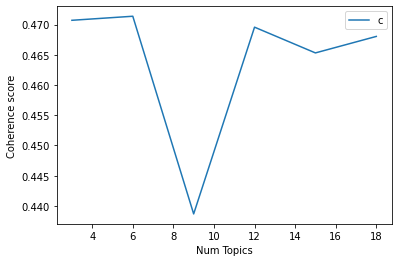

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

limit=21; start=3; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.4707
Num Topics = 6  has Coherence Value of 0.4714
Num Topics = 9  has Coherence Value of 0.4387
Num Topics = 12  has Coherence Value of 0.4696
Num Topics = 15  has Coherence Value of 0.4653
Num Topics = 18  has Coherence Value of 0.468


In [24]:
# select the model based on the coherence-score elbow-plot 
optimal_model = model_list[4]
filename = 'Euronews_model.sav'
pickle.dump(optimal_model, open(filename, 'wb'))
optimal_model = joblib.load(filename)

In [25]:
# Select the model and print the topics
model_topics = optimal_model.show_topics(formatted=False)
print("Topics for the chosen LDA model:\n")
pprint(optimal_model.print_topics(num_words=10))

Topics for the chosen LDA model:

[(0,
  '0.050*"eu" + 0.045*"european" + 0.023*"crisis" + 0.021*"europe" + '
  '0.015*"country" + 0.014*"commission" + 0.012*"member_state" + 0.010*"plan" '
  '+ 0.010*"economy" + 0.008*"leader"'),
 (1,
  '0.050*"lockdown" + 0.041*"people" + 0.029*"measure" + 0.027*"country" + '
  '0.022*"restriction" + 0.020*"week" + 0.016*"school" + 0.015*"government" + '
  '0.015*"social_distance" + 0.014*"reopen"'),
 (2,
  '0.023*"world" + 0.019*"pandemic" + 0.017*"global" + 0.011*"crisis" + '
  '0.011*"china" + 0.009*"war" + 0.008*"country" + 0.008*"animal" + '
  '0.007*"outbreak" + 0.007*"europe"'),
 (3,
  '0.056*"people" + 0.050*"work" + 0.017*"home" + 0.014*"food" + '
  '0.013*"worker" + 0.012*"time" + 0.010*"family" + 0.008*"lockdown" + '
  '0.008*"service" + 0.008*"day"'),
 (4,
  '0.015*"police" + 0.014*"president" + 0.012*"protest" + 0.011*"people" + '
  '0.010*"election" + 0.010*"year" + 0.009*"russia" + 0.008*"party" + '
  '0.008*"political" + 0.007*"vote"'

In [ ]:
#Finding the dominant topic in each sentence

In [27]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [30]:
df_topic_sents_keywords = format_topics_sentences(ldamodel = optimal_model, corpus = corpus, texts = data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.sample(10)
df_dominant_topic.to_excel('LDA_Euronews_colab.xlsx', index = False)
df_dominant_topic.sample(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
1234,1234,7.0,0.3459,"health, pandemic, make, service, company, worl...",charitable initiatives launched federal le...
1127,1127,12.0,0.4718,"time, thing, day, back, life, world, home, mak...",european artists paparazzi connor brothers ...
170,170,13.0,0.1867,"country, travel, quarantine, border, china, pa...",several spanish bound planes turned back mid a...
728,728,3.0,0.5195,"people, work, home, food, worker, time, family...",million orthodox christians celebrating...
1077,1077,12.0,0.1727,"time, thing, day, back, life, world, home, mak...",costume clad locals us state michigan dre...
1037,1037,1.0,0.3151,"lockdown, people, measure, country, restrictio...",spain regions hospitals show able handle...
28,28,13.0,0.2420,"country, travel, quarantine, border, china, pa...",public transport drivers moscow urged rais...
1008,1008,0.0,0.2453,"eu, european, crisis, europe, country, commiss...",eu expressed regret opinion article chin...
500,500,8.0,0.2714,"uk, government, prime_minister, british, add, ...",ireland prime minister leo varadkar go back ...
738,738,1.0,0.1459,"lockdown, people, measure, country, restrictio...",look life lockdown germany beginning tak...


In [ ]:
#Find the most representative document for each topic

In [32]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]


sent_topics_sorteddf_mallet.to_excel('LDA_Euronews_colab_rep.xlsx', index = False)
# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6670,"eu, european, crisis, europe, country, commiss...",could pandemic force european union break ...
1,1.0,0.5409,"lockdown, people, measure, country, restrictio...",many european countries begun implementing te...
2,2.0,0.5423,"world, pandemic, global, crisis, china, war, c...",another country accidentally unleashed weapo...
3,3.0,0.5195,"people, work, home, food, worker, time, family...",million orthodox christians celebrating...
4,4.0,0.8435,"police, president, protest, people, election, ...",one say line presidential election bela...
5,5.0,0.5515,"hospital, health, people, test, virus, trump, ...",days resistance president donald trump said...
6,6.0,0.6190,"case, country, death, italy, number, report, s...",premier league suspended least april du...
7,7.0,0.5664,"health, pandemic, make, service, company, worl...",interpol warned people vigilant fraudsters...
8,8.0,0.4828,"uk, government, prime_minister, british, add, ...",london brussels resume post brexit talks mon...
9,9.0,0.5257,"government, emergency, law, state, data, publi...",third planet population still related r...


In [38]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()
topic_num_keywords = topic_num_keywords.set_index('Dominant_Topic')

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
#df_dominant_topics


df_dominant_topics.sort_values('Num_Documents', ascending = False).to_excel('LDA_Euronews_colab_topics.xlsx', index = True)
#
pprint(df_dominant_topics.Topic_Keywords)

0.0     eu, european, crisis, europe, country, commiss...
1.0     lockdown, people, measure, country, restrictio...
2.0     world, pandemic, global, crisis, china, war, c...
3.0     people, work, home, food, worker, time, family...
4.0     police, president, protest, people, election, ...
5.0     hospital, health, people, test, virus, trump, ...
6.0     case, country, death, italy, number, report, s...
7.0     health, pandemic, make, service, company, worl...
8.0     uk, government, prime_minister, british, add, ...
9.0     government, emergency, law, state, data, publi...
10.0    year, economy, economic, job, business, compan...
11.0    mask, face, city, france, french, wear, order,...
12.0    time, thing, day, back, life, world, home, mak...
13.0    country, travel, quarantine, border, china, pa...
14.0    virus, vaccine, disease, people, test, study, ...
Name: Topic_Keywords, dtype: object


In [ ]:
#Topic Trending Viz

In [37]:
df_dominant_topic_date = pd.concat([df['published_date'].reset_index(), df_dominant_topic], axis = 1)
df_dominant_topic_date.to_excel('Euronews_dominant_topic_date.xlsx', index = False)

# df_dominant_topic_date.groupby(['true_time','Dominant_Topic']).agg('count')
agg_topicandtime = pd.pivot_table(df_dominant_topic_date, index=['published_date'], values = ['Document_No'], columns = ['Dominant_Topic'], aggfunc = 'count')
agg_topicandtime.to_excel('Euronews_agg_topicandtime.xlsx')

In [40]:
EuroNewsDF.to_excel('Euronews_full.xlsx')